# Understanding Structured Point Clouds (SPCs)

Structured Point Clouds (SPC) is a differentiable, GPU-compatible, spatial-data structure which efficiently organizes 3D geometrically sparse information in a very compressed manner.

![alt text](../samples/spcTeapot.png "Structured Point Cloud Hierarchy")

<b> When should you use it? </b>
* The SPC data structure is very general, which makes it <mark>a suitable building block for a variety of applications</mark>.
* Examples include: 
    * [Representation & rendering of implicit 3D surfaces](https://nv-tlabs.github.io/nglod/)
    * Convolutions on voxels, meshes and point clouds
    * and more..

SPCs are easily convertible from point clouds and meshes, and can be optimized to represent encoded neural implicit fields.

<b> In this tutorial you will learn to: </b>
1. Construct a SPC from triangular meshes and point clouds.
2. Visualize the SPC using ray-tracing functionality.
3. Become familiar with the internals of kaolin's SPC data structure

Practitioners are encouraged to view the [documentation](https://kaolin.readthedocs.io/en/latest/modules/kaolin.ops.spc.html?highlight=spc#kaolin-ops-spc) for additional details about the internal workings of this data structure. <br>
This tutorial is best run locally to observe the full output.

## Setup

This tutorial assumes a minimal version of [kaolin v0.10.0](https://kaolin.readthedocs.io/en/latest/notes/installation.html). <br>
In addition, the following libraries are required for this tutorial:

In [1]:
!pip install -q matplotlib
!pip install -q termcolor
!pip install -q ipywidgets

In [2]:
from PIL import Image
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from termcolor import colored

import kaolin as kal
from spc_formatting import describe_octree, color_by_level

To study the mechanics of the SPC structure, we'll need some auxilary functions (you may skip for now): <br>

In [3]:
def describe_tensor(torch_tensor, tensor_label, with_content):
    print(kal.utils.testing.tensor_info(torch_tensor, name=tensor_label))
    if with_content:
        print(f'Raw Content: \n{torch_tensor.cpu().numpy()}')
        

def convert_texture_to_torch_sample_format(texture):
    """ Convert to (1, C, Tex-H, Tex-W) format """
    return texture.unsqueeze(0).type(sampled_uvs.dtype).permute(0, 3, 1, 2)

### Preliminaries: Load Mesh and sample as Point Cloud

Throughout this tutorial we'll be using a triangular mesh as an example. <br>
First, we import the mesh using kaolin:

In [4]:
# Path to some .obj file with textures
mesh_path = "../samples/colored_sphere.obj"
mesh = kal.io.obj.import_mesh(mesh_path, with_materials=True)

# We convert mesh to fixed batching strategy, expected by the sampling function
mesh = mesh.to_batched().cuda()
print(mesh)

SurfaceMesh object with batching strategy FIXED
            vertices: [1, 642, 3] (torch.float32)[cuda:0]  
                 uvs: [1, 671, 2] (torch.float32)[cuda:0]  
               faces: [1280, 3] (torch.int64)[cuda:0]  
        face_uvs_idx: [1, 1280, 3] (torch.int64)[cuda:0]  
material_assignments: [1, 1280] (torch.int16)[cuda:0]  
           materials: list of length 1
      vertex_normals: will be computed on access from (if present): (faces, face_normals)
        face_normals: will be computed on access from (if present): (normals, face_normals_idx) or (vertices, faces)
            face_uvs: will be computed on access from (if present): (uvs, face_uvs_idx)
       face_vertices: will be computed on access from (if present): (faces, vertices)


Next, we'll oversample the mesh faces to make sure our SPC structure is densely populated and avoids "holes"
at the highest resolution level.

Note that our mesh face-vertices are mapped to some texture coordinates.
Luckily, kaolin has a `sample_points` function that will take care of interpolating these coordinates for us. 
The sampled vertices will be returned along with the interpolated uv coordinates as well:

In [5]:
# Sample points over the mesh surface, interpolating face uv coordinates
num_samples = 1000000
sampled_verts, _, sampled_uvs = kal.ops.mesh.trianglemesh.sample_points(mesh.vertices,
                                                                        mesh.faces,
                                                                        num_samples=num_samples,
                                                                        face_features=mesh.face_uvs)

print(f'Sampled {sampled_verts.shape[1]} points over the mesh surface:')
print(f'sampled_verts is a tensor with batch size {sampled_verts.shape[0]},',
      f'with {sampled_verts.shape[1]} points of {sampled_verts.shape[2]}D coordinates.')

print(f'sampled_uvs is a tensor with batch size {sampled_uvs.shape[0]},',
      f'representing the corresponding {sampled_uvs.shape[1]} {sampled_uvs.shape[2]}D UV coordinates.')

Sampled 1000000 points over the mesh surface:
sampled_verts is a tensor with batch size 1, with 1000000 points of 3D coordinates.
sampled_uvs is a tensor with batch size 1, representing the corresponding 1000000 2D UV coordinates.


To finish our setup, we'll want to use the UV coordinates to perform texture sampling and obtain the RGB color of each point we have:

In [6]:
# Convert texture to sample-compatible format
diffuse_color = mesh.materials[0][0]['map_Kd']    # Assumes a shape with a single material
texture_maps = convert_texture_to_torch_sample_format(diffuse_color) # (1, C, Th, Tw)
texture_maps = texture_maps.cuda()

# Sample colors according to uv-coordinates
sampled_uvs = kal.render.mesh.utils.texture_mapping(texture_coordinates=sampled_uvs,
                                                    texture_maps=texture_maps,
                                                    mode='nearest')
# Unbatch
vertices = sampled_verts.squeeze(0)
vertex_colors = sampled_uvs.squeeze(0)

# Normalize to [0,1]
vertex_colors /= 255

describe_tensor(vertices, 'vertices', with_content=False)
describe_tensor(vertex_colors, 'vertex_colors', with_content=False)

vertices: [1000000, 3] (torch.float32)[cuda:0]  
vertex_colors: [1000000, 3] (torch.float32)[cuda:0]  


## 1. Create & Visualize SPC

### Create the SPC

We start by converting our Point Cloud of continuous 3D coordinates to a Structured Point Cloud. <br>

`unbatched_pointcloud_to_spc` will return a `Spc` object, a data class holding all Structured Point Cloud related information. <br>
At the core of this object, points are kept in quantized coordinates using a compressed octree. <br>

The returned object contains multiple low-level data structures which we'll explore in details in the next section.
For now keep in mind that its important fields: `octree`, `features`, `point_hierarchy`, `pyramid` and `prefix`, represent our data structure.

When constructing a `Spc` object, the resolution of quantized coordinates can be controlled by the octree `level` arg, such that: $resolution=2^{level}$

In [7]:
# Our SPC will contain a hierarchy of multiple levels
level = 3
spc = kal.ops.conversions.pointcloud.unbatched_pointcloud_to_spc(vertices, level, features=vertex_colors)

### Set-up the camera

The SPC data structure can be efficiently visualized using ray-tracing ops. <br>

Note that SPC also supports differentiable rendering. In this tutorial we'll limit our demonstration to rendering this data structure efficiently. <br>
Differentiable ray-tracing is beyond the scope of this guide, and will be covered in future tutorials.

To begin our ray tracing implementation, we'll first need to set up our camera view and [generate some rays](https://www.scratchapixel.com/lessons/3d-basic-rendering/ray-tracing-generating-camera-rays). <br>
We'll assume a pinhole camera model, and use the `look_at` function, which sets up a camera view originating at position `camera_from`, looking towards `camera_to`. <br>
`width`, `height`, `mode` and `fov` will determine the dimensions of our view.

In [8]:
def _normalized_grid(width, height, device='cuda'):
    """Returns grid[x,y] -> coordinates for a normalized window.
    
    Args:
        width, height (int): grid resolution
    """

    # These are normalized coordinates
    # i.e. equivalent to 2.0 * (fragCoord / iResolution.xy) - 1.0
    window_x = torch.linspace(-1, 1, steps=width, device=device) * (width / height)
    window_y = torch.linspace(1,- 1, steps=height, device=device)

    coord = torch.stack(torch.meshgrid(window_x, window_y)).permute(1,2,0)
    return coord


def look_at(camera_from, camera_to, width, height, mode='persp', fov=90.0, device='cuda'):
    """Vectorized look-at function, returns an array of ray origins and directions
    URL: https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/lookat-function
    """

    camera_origin = torch.FloatTensor(camera_from).to(device)
    camera_view = F.normalize(torch.FloatTensor(camera_to).to(device) - camera_origin, dim=0)
    camera_right = F.normalize(torch.cross(camera_view, torch.FloatTensor([0,1,0]).to(device)), dim=0)
    camera_up = F.normalize(torch.cross(camera_right, camera_view), dim=0)

    coord = _normalized_grid(width, height, device=device)
    ray_origin = camera_right * coord[...,0,np.newaxis] * np.tan(np.radians(fov/2)) + \
                 camera_up * coord[...,1,np.newaxis] * np.tan(np.radians(fov/2)) + \
                 camera_origin + camera_view
    ray_origin = ray_origin.reshape(-1, 3)
    ray_offset = camera_view.unsqueeze(0).repeat(ray_origin.shape[0], 1)
    
    if mode == 'ortho': # Orthographic camera
        ray_dir = F.normalize(ray_offset, dim=-1)
    elif mode == 'persp': # Perspective camera
        ray_dir = F.normalize(ray_origin - camera_origin, dim=-1)
        ray_origin = camera_origin.repeat(ray_dir.shape[0], 1)
    else:
        raise ValueError('Invalid camera mode!')


    return ray_origin, ray_dir

Now generate some rays using the functions we've just created:

In [9]:
# ray_o and ray_d ~ torch.Tensor (width x height, 3)
# represent rays origin and direction vectors
ray_o, ray_d = look_at(camera_from=[-2.5,2.5,-2.5],
                       camera_to=[0,0,0],
                       width=1024,
                       height=1024,
                       mode='persp',
                       fov=30,
                       device='cuda')

print(f'Total of {ray_o.shape[0]} rays generated.')

Total of 1048576 rays generated.


/home/mshugrina/anaconda3/envs/kaolin-dev/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Render

We're now ready to perform the actual ray tracing. <br>
kaolin will "shoot" the rays for us, and perform an efficient intersection test between each ray and cell within the SPC structure. <br>
In kaolin terminology, <b>nuggets</b> are "ray-cell intersections" (or rather "ray-point" intersections).

<b>nuggets </b> are of represented by a structure of two tensors: `nugs_ridx` and `nugs_pidx`, <br>which form together pairs of `(index_to_ray, index_to_points)`. <br>
Both tensors are 1-dimensional tensors of shape (`#num_intersection`,).

In [10]:
octree, features = spc.octrees, spc.features
point_hierarchy, pyramid, prefix = spc.point_hierarchies, spc.pyramids[0], spc.exsum
nugs_ridx, nugs_pidx, depth = kal.render.spc.unbatched_raytrace(octree, point_hierarchy, pyramid, prefix, ray_o, ray_d, level)
print(f'Total of {nugs_ridx.shape[0]} nuggets were traced.\n')

Total of 1195190 nuggets were traced.



Since we're assuming here our surface is opaque, for each ray, we only care about the <b>nugget</b>
closest to the camera. <br>
Note that per "ray-pack", the returned <b>nuggets</b> are already sorted by depth. <br>
The method below returns a boolean mask which specifies which <b>nuggets</b> represent a "first-hit".

In [11]:
masked_nugs = kal.render.spc.mark_pack_boundaries(nugs_ridx)
nugs_ridx = nugs_ridx[masked_nugs]
nugs_pidx = nugs_pidx[masked_nugs]

Finally, for each ray that hit the surface, a corresponding "first-hit" nugget exists. <br>

In [12]:
# 1. We initialize an empty canvas.
image = torch.ones_like(ray_o)

# 2. We'll query all first-hit nuggets to obtain their corresponding point-id (which cell they hit in the SPC).
ridx = nugs_ridx.long()
pidx = nugs_pidx.long() - pyramid[1,level]

# 3. We'll query the features auxilary structure to obtain the color.
# 4. We set each ray value as the corresponding nugget color.
image[ridx] = features[pidx]

image = image.reshape(1024, 1024, 3)

Putting it all together, we write our complete `render()` function and display the trace using matplotlib:

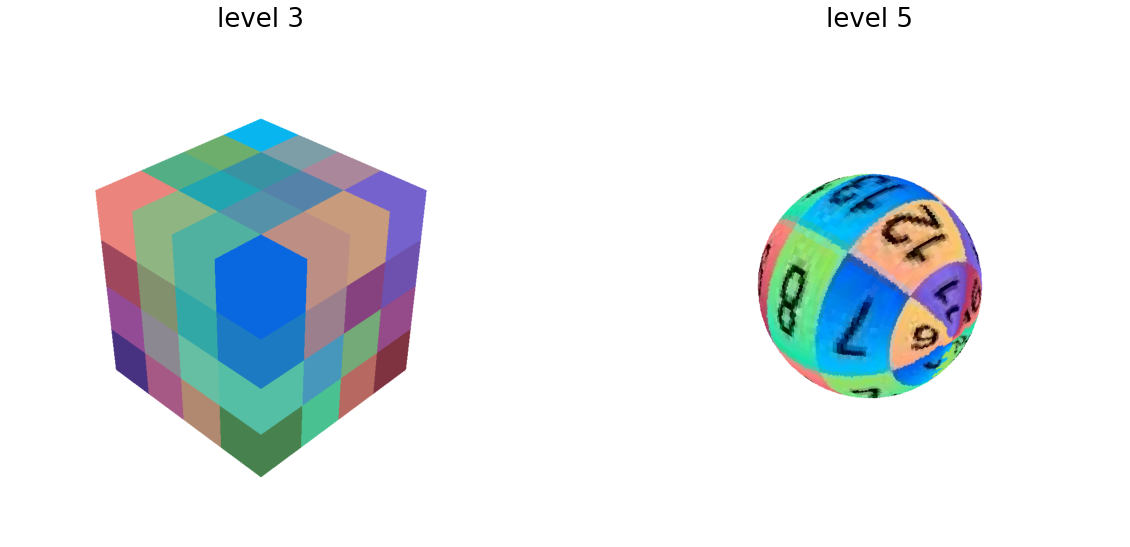

In [13]:
import matplotlib.pyplot as plt

def render(level):
    """ Create & render an image """
    spc = kal.ops.conversions.pointcloud.unbatched_pointcloud_to_spc(vertices, level, vertex_colors)
    octree, features, point_hierarchy, pyramid, prefix = spc.octrees, spc.features, spc.point_hierarchies, spc.pyramids[0], spc.exsum
    
    nugs_ridx, nugs_pidx, depth = kal.render.spc.unbatched_raytrace(octree, point_hierarchy, pyramid, prefix, ray_o, ray_d, level)
    masked_nugs = kal.render.spc.mark_pack_boundaries(nugs_ridx)
    nugs_ridx = nugs_ridx[masked_nugs]
    nugs_pidx = nugs_pidx[masked_nugs]
    
    ridx = nugs_ridx.long()
    pidx = nugs_pidx.long() - pyramid[1,level]
    image = torch.ones_like(ray_o)
    image[ridx] = features[pidx]
    image = image.reshape(1024, 1024, 3)
    return image


fig = plt.figure(figsize=(20,10))

# Render left image of level 3 SPC
image1 = render(level=3)
image1 = image1.cpu().numpy().transpose(1,0,2)
ax = fig.add_subplot(1, 2, 1)
ax.set_title("level 3", fontsize=26)
ax.axis('off')
plt.imshow(image1)

# Render right image of level 5 SPC
image2 = render(level=8)
image2 = image2.cpu().numpy().transpose(1,0,2)
ax = fig.add_subplot(1, 2, 2)
ax.set_title("level 5", fontsize=26)
ax.axis('off')
plt.imshow(image2)

plt.show()

Finally, putting it all together, we may also construct the following interactive demo:

In [14]:
def update_demo(widget_spc_level):
    image = render(widget_spc_level)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(image.cpu().numpy().transpose(1,0,2))
    plt.show()

def show_interactive_demo(max_level=10):
    start_value = min(7, max_level)
    widget_spc_level = widgets.IntSlider(value=start_value, min=1, max=max_level, step=1, orientation='vertical',
                                     description='<h5>SPC Level:</h5>', disabled=False,
                                     layout=widgets.Layout(height='100%',))
    
    out = widgets.interactive_output(update_demo, {'widget_spc_level': widget_spc_level})
    display(widgets.HBox([widgets.VBox([widget_spc_level]), out]))

show_interactive_demo()

## 2. SPC internals

In this section we'll explore the various components that make up the [SPC](https://kaolin.readthedocs.io/en/latest/modules/kaolin.ops.spc.html?highlight=spc#structured-point-clouds) we've just created. <br>
We'll learn how data is stored, and how to view stored data.

### Boilerplate code

Let's rebuild our SPC object with fewer levels, that will make the internals easier to study. <br>
You may customize the number of levels and compare how the output changes.

In [15]:
level = 3
spc = kal.ops.conversions.pointcloud.unbatched_pointcloud_to_spc(vertices, level, features=vertex_colors)

Ok, let's see what we've got.

### octree

The first field we'll look into, `octrees`, keeps the entire geometric structure in a compressed manner. <br>
This is a huge advantage, as this structure is now small enough to fit our sparse data, which makes it very efficient.

In [16]:
octree = spc.octrees

In [17]:
describe_tensor(torch_tensor=octree, tensor_label='octree', with_content=True)

print(f'\n"octrees" represents a hierarchy of {len(octree)} octree nodes.')
print(f"Let's have a look at the binary representation and what it means:\n")

describe_octree(octree, level)

text_out = widgets.Output(layout={'border': '0.2px dashed black'})
with text_out:
    print('How to read the content of octrees?')
    print('- Each entry represents a single octree of 8 cells --> 8 bits.')
    print('- The bit position determines the cell index, in Morton Order.')
    print('- The bit value determines if the cell is occupied or not.')
    print(f'- If a cell is occupied, an additional octree may be generated in the next level, up till level {level}.')
    print('For example, an entry of 00000001 is a single level octree, where only the bottom-left most cell is occupied.')
    
display(widgets.HBox([text_out]))

octree: [17] (torch.uint8)[cuda:0]  
Raw Content: 
[255 128  64  32  16   8   4   2   1 127 191 223 239 247 251 253 254]

"octrees" represents a hierarchy of 17 octree nodes.
Let's have a look at the binary representation and what it means:

Level #1, Path*,        11111111
Level #2, Path*-1,      10000000
Level #2, Path*-2,      01000000
Level #2, Path*-3,      00100000
Level #2, Path*-4,      00010000
Level #2, Path*-5,      00001000
Level #2, Path*-6,      00000100
Level #2, Path*-7,      00000010
Level #2, Path*-8,      00000001
Level #3, Path*-1-8,    01111111
Level #3, Path*-2-7,    10111111
Level #3, Path*-3-6,    11011111
Level #3, Path*-4-5,    11101111
Level #3, Path*-5-4,    11110111
Level #3, Path*-6-3,    11111011
Level #3, Path*-7-2,    11111101
Level #3, Path*-8-1,    11111110


##### Order of octants within partitioned cells
![alt text](../samples/octants.png "Octants")

Notice the field is named in plural.
That's because kaolin can batch multiple instances of octrees together within the same object. <br>

In [18]:
print(spc.batch_size)

1


Pay attention that `octrees` uses [packed representation](https://kaolin.readthedocs.io/en/latest/modules/kaolin.ops.batch.html?highlight=packed#packed), meaning, there is no explicit batch dimension. <br>
Instead, we track the length of each octree instance in a separate field:

In [19]:
octrees_lengths = spc.lengths
describe_tensor(torch_tensor=octrees_lengths, tensor_label='lengths', with_content=True)

text_out = widgets.Output(layout={'border': '0.2px dashed black'})
with text_out:
    print('How to read the content of lengths?')
    print(f'- This Spc stores a batch of {len(spc.lengths)} octrees.')
    print(f'- The first octree is represented by {spc.lengths[0]} non-leaf cells.')
    print(f'- Therefore the information of the first octree is kept in bytes 0-{spc.lengths[0]-1} of the octrees field.')
    
display(widgets.HBox([text_out]))

lengths: [1] (torch.int32)[cpu]  
Raw Content: 
[17]


Advanced users who prefer a non object-oriented lower-level api can also use the following functionality which `kal.ops.conversions.pointcloud.unbatched_pointcloud_to_spc` employs under the hood:

In [20]:
from kaolin.ops.spc.points import quantize_points, points_to_morton, morton_to_points, unbatched_points_to_octree

# Construct a batch of 2 octrees. For brevity, we'll use the same ocuupancy data for both.
# 1. Convert continous to quantized coordinates
# 2. Build the octrees

points1 = quantize_points(vertices.contiguous(), level=2)
octree1 = unbatched_points_to_octree(points1, level=2)

points2 = quantize_points(vertices.contiguous(), level=3)
octree2 = unbatched_points_to_octree(points2, level=3)

# Batch 2 octrees together. For packed representations, this is just concatenation.
octrees = torch.cat((octree1, octree2), dim=0)
lengths = torch.tensor([len(octree1), len(octree2)], dtype=torch.int32)

describe_tensor(torch_tensor=octrees, tensor_label='octrees', with_content=True)
print('')
describe_tensor(torch_tensor=lengths, tensor_label='lengths', with_content=True)

octrees: [26] (torch.uint8)[cuda:0]  
Raw Content: 
[255 128  64  32  16   8   4   2   1 255 128  64  32  16   8   4   2   1
 127 191 223 239 247 251 253 254]

lengths: [2] (torch.int32)[cpu]  
Raw Content: 
[ 9 17]


These structures form the bare minimum required to shift back to high-level api and construct a Spc object:

In [21]:
kal.rep.spc.Spc(octrees, lengths)

### features

So far we've lookied into how Structured Point Clouds keep track of occupancy. <br>
Next we'll study how they keep track of features.

The `features` field contains features information per cell.

In [22]:
features = spc.features

In [23]:
def paint_features(features):
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(features.cpu().numpy()[None])
    plt.show()
    
print('In this tutorial, cell features are RGB colors:')
describe_tensor(torch_tensor=features, tensor_label='features', with_content=False)
paint_features(features)

text_out = widgets.Output(layout={'border': '0.2px dashed black'})
with text_out:
    print('How to read the content of features?')
    print(f'- We keep features only for leaf cells, a total of {features.shape[0]}.')
    print(f'- The number of leaf cells can be obtained by summarizing the "1" bits at level {spc.max_level},\n' \
    '  the last level of the octree.')
    print(f'- The dimensionality of each attribute is {features.shape[1]} (e.g: RGB channels)')
    print('\nReminder - the highest level of occupancy octree is:')
    describe_octree(spc.octrees, level, limit_levels=[spc.max_level])
    

display(widgets.HBox([text_out]))

In this tutorial, cell features are RGB colors:
features: [56, 3] (torch.float32)[cuda:0]  


### pyramid & exsum

Since the occupancy information is [compressed](https://kaolin.readthedocs.io/en/latest/modules/kaolin.ops.spc.html?highlight=spc#octree) and [packed](https://kaolin.readthedocs.io/en/latest/modules/kaolin.ops.batch.html?highlight=packed#packed), accessing level-specific information consistently involves
cumulative summarization of the number of "1" bits. <br>
It makes sense to calculate this information once and then cache it. <br>
The `pyramid` field does exactly that: it keeps summarizes the number of occupied cells per level, and their cumsum, for fast level-indexing.

In [24]:
# A pyramid is kept per octree in the batch.
# We'll study the pyramid of the first and only entry in the batch.
pyramid = spc.pyramids[0]

In [25]:
describe_tensor(torch_tensor=pyramid, tensor_label='pyramid', with_content=True)

out_left = widgets.Output(layout={'border': '0.2px dashed black'})
out_right = widgets.Output(layout={'border': '0.2px dashed black'})

print('\nHow to read the content of pyramids?')

with out_left:
    print('"pyramid" summarizes the number of occupied \ncells per level, and their cumulative sum:\n')
    for i in range(pyramid.shape[-1]):
        if i ==0:
            print(f'Root node (implicitly defined):')
        elif i+1 < pyramid.shape[-1]:
            print(f'Level #{i}:')
        else:
            print(f'Final entry for total cumsum:')
        print(f'\thas {pyramid[0,i]} occupied cells')
        print(f'\tstart idx (cumsum excluding current level): {pyramid[1,i]}')
        
with out_right:
    print(f'"octrees" represents a hierarchy of {len(spc.octrees)} octree nodes.')
    print(f"Each bit represents a cell occupancy:\n")
    describe_octree(octree, level)
    
    
display(widgets.HBox([out_left, out_right]))

pyramid: [2, 5] (torch.int32)[cpu]  
Raw Content: 
[[ 1  8  8 56  0]
 [ 0  1  9 17 73]]

How to read the content of pyramids?


Similarly, kaolin keeps a complementary field, `exsum`, which tracks the cumulative summarization of bits per-octree to fast access parent-child information between levels:

In [26]:
exsum = spc.exsum

In [27]:
describe_tensor(torch_tensor=exsum, tensor_label='exsum', with_content=True)

out_left = widgets.Output(layout={'border': '0.2px dashed black'})
out_right = widgets.Output(layout={'border': '0.2px dashed black'})

print('\nHow to read the content of exsum?')

with out_left:
    print('"exsum" summarizes the cumulative number of occupied \ncells per octree, e.g: exclusive sum of "1" bits:\n')
    for i in range(exsum.shape[-1]):
        print(f'Cells in Octree #{i} start from cell idx: {exsum[i]}')
        
with out_right:
    print(f'"octrees" represents a hierarchy of {len(octree)} octree nodes.')
    print(f"Each bit represents a cell occupancy:\n")
    describe_octree(octree, level)
    
    
display(widgets.HBox([out_left, out_right]))

exsum: [18] (torch.int32)[cuda:0]  
Raw Content: 
[ 0  8  9 10 11 12 13 14 15 16 23 30 37 44 51 58 65 72]

How to read the content of exsum?


When using Spc objects, pyramids are implicitly created the first time they are needed so you don't have to worry about them. <br>
For advanced users, the low-level api allows their explicit creation through `scan_octrees`:

In [28]:
lengths = torch.tensor([len(octrees)], dtype=torch.int32)
max_level, pyramid, exsum = kal.ops.spc.spc.scan_octrees(octree, lengths)

print('max_level:')
print(max_level)

print('\npyramid:')
print(pyramid)

print('\nexsum:')
print(exsum)

max_level:
3

pyramid:
tensor([[[ 1,  8,  8, 56,  0],
         [ 0,  1,  9, 17, 73]]], dtype=torch.int32)

exsum:
tensor([ 0,  8,  9, 10, 11, 12, 13, 14, 15, 16, 23, 30, 37, 44, 51, 58, 65, 72,
        72, 72, 72, 72, 72, 72, 72, 74, 74], device='cuda:0',
       dtype=torch.int32)


### point_hierarchies

`point_hierarchies` is an auxilary field, which holds the *sparse* coordinates of each point / occupied cell within the octree, for easier access.

Sparse coordinates are packed for all cells on all levels combined.

In [29]:
describe_tensor(torch_tensor=spc.point_hierarchies, tensor_label='point_hierarchies', with_content=False)

point_hierarchies: [73, 3] (torch.int16)[cuda:0]  


We can use the information stored in the pyramids field to color the coordinates by level:

In [30]:
out_left = widgets.Output(layout={'border': '0.2px dashed black'})
out_right = widgets.Output(layout={'border': '0.2px dashed black', 'width': '60%'})

max_points_to_display = 17  # To avoid clutter

with out_left:
    level_idx =0
    point_idx = 0
    remaining_cells_per_level = spc.pyramids[0,0].cpu().numpy().tolist()

    for coord in spc.point_hierarchies:
        remaining_cells_per_level[level_idx] -= 1

        if point_idx == max_points_to_display:
            print(colored(f'skipping more..', level_color))
        elif point_idx < max_points_to_display:
            level_color = color_by_level(level_idx - 1)
            print(colored(f'Level #{level_idx}, Point #{point_idx}, ' \
                          f'Coords: {coord.cpu().numpy().tolist()}', level_color))

        if not remaining_cells_per_level[level_idx]:
            level_idx += 1
            point_idx = 0
        else:
            point_idx += 1

with out_right:
    print('How to read the content of point_hierarchies?')
    print(f'- Each cell / point is represented by {spc.point_hierarchies.shape[-1]} indices (xyz).')
    print('- Sparse coordinates are absolute: \n  they are defined relative to the octree origin.')    
    print('- Compare the point coordinates with the demo below.\n\n  Remember: unoccupied cells are not displayed!')
    show_interactive_demo(max_level=spc.max_level)

display(widgets.HBox([out_left, out_right]))

## Where to go from here

Structured Point Clouds support other useful operators which were not covered by this tutorial:

1. [Convolutions](https://kaolin.readthedocs.io/en/latest/modules/kaolin.ops.spc.html?highlight=SPC#kaolin.ops.spc.Conv3d)
2. [Querying points by location](https://kaolin.readthedocs.io/en/latest/modules/kaolin.ops.spc.html?highlight=SPC#kaolin.ops.spc.unbatched_query)
3. [Differential ray-tracing ops](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.spc.html#kaolin-render-spc)
